In [1]:
import warnings
from transformers import logging as transformers_logging
# Suppress specific warnings
warnings.filterwarnings("ignore")

import argparse
import os
import shutil
import sys
import time
from functools import partial
import json
import re
import copy
import deepspeed
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import tqdm
import transformers
from peft import LoraConfig, get_peft_model
from torch.utils.tensorboard import SummaryWriter
from llava_aff.model.mask_decoder.mask_decoder import Neck, MaskDecoder
from llava_aff.model.mask_decoder.prompt_encoder import PromptEncoder
from llava_aff.model.mask_decoder.twowaytrans import TwoWayTransformer
from llava_aff.model.mask_decoder.common import LayerNorm2d
from llava_aff.model.AFF import AffordanceForCasualLM

from llava_aff.util.utils import (IGNORE_INDEX, IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_END_TOKEN, DEFAULT_IM_START_TOKEN,
                         AverageMeter, ProgressMeter, Summary, dict_to_cuda,
                         intersectionAndUnionGPU, extract_item_category, cal_kl, cal_sim, cal_nss, WeightedFocalLoss)
from llava_aff.mm_utils import tokenizer_image_token
from llava_aff.util.data_gen import preprocess_v1, preprocess_plain, preprocess_multimodal, preprocess, collate_fn, LazySupervisedDataset, make_supervised_data_module

[2024-10-16 19:02:47,571] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "lmsys/vicuna-7b-v1.5",
    cache_dir=None,
    model_max_length=2048,
    padding_side="right",
    use_fast=False,
)

tokenizer.pad_token = tokenizer.unk_token
num_added_tokens = tokenizer.add_tokens("<seg_patch>")
seg_token_idx = tokenizer("<seg_patch>", add_special_tokens=False).input_ids[-1]

save_output_dir = "output_inference"
model_args = {
        "train_mask_decoder": True,
        "mm_patch_merge_type": 'flat',
        "out_dim": 256,
        "ce_loss_weight": 1.0,
        "dice_loss_weight": 0.5,
        "bce_loss_weight": 2.0,
        "seg_token_idx": seg_token_idx,
        "save_output_dir": save_output_dir,
        "vision_pretrained": "None",
        "vision_tower": "google/owlvit-base-patch32",
        "use_mm_start_end": True,
        "mm_vision_select_layer": -2,
        "mm_hidden_size": 768,
        "stage": "finetune",
        "mm_projector_type": "mlp2x_gelu",
    }

torch_dtype = torch.bfloat16
transformers_logging.set_verbosity_error()
model = AffordanceForCasualLM.from_pretrained(
        "lmsys/vicuna-7b-v1.5", torch_dtype=torch_dtype, low_cpu_mem_usage=False, **model_args
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.enable_input_require_grads()
model.gradient_checkpointing_enable()
model.get_model().initialize_vision_modules(model.get_model().config)
vision_tower = model.get_model().get_vision_tower()
vision_tower.to(dtype=torch_dtype, device=0)

model.resize_token_embeddings(len(tokenizer))

load_mm_projector_file_path = "mm_projector.bin" ## path
print("before loaded\n", model.model.mm_projector[0].weight.data)
temp_weight_file = load_mm_projector_file_path
temp_wegith_checkpoint = torch.load(temp_weight_file)
print(temp_wegith_checkpoint["mm_projector.0.weight"])
for key in list(temp_wegith_checkpoint.keys()):
    temp_key = "model." + key
    temp_array = temp_wegith_checkpoint.pop(key)
    temp_wegith_checkpoint[temp_key] = temp_array
model.load_state_dict(temp_wegith_checkpoint, strict=False)
print("after loaded\n", model.model.mm_projector[0].weight.data)

before loaded
 tensor([[ 3.9062e-02, -1.7212e-02,  1.4603e-05,  ...,  4.8828e-03,
          1.0254e-02, -1.1902e-02],
        [-1.0193e-02, -1.1597e-02, -1.2512e-02,  ..., -2.5391e-02,
          1.2878e-02, -1.0681e-03],
        [ 7.3624e-04, -1.8433e-02, -8.5449e-03,  ..., -1.6602e-02,
          1.0605e-03, -1.8768e-03],
        ...,
        [-1.3123e-02, -2.0630e-02, -5.7983e-03,  ..., -7.8735e-03,
          1.2878e-02, -6.7139e-03],
        [ 3.7109e-02, -3.1982e-02,  4.1199e-03,  ..., -1.7456e-02,
          1.9409e-02, -6.4087e-03],
        [-2.3438e-02,  1.0147e-03,  1.3367e-02,  ..., -4.4678e-02,
          3.0756e-05, -9.2163e-03]], dtype=torch.bfloat16)
tensor([[-0.0009,  0.0146, -0.0182,  ..., -0.0037,  0.0479, -0.0250],
        [ 0.0132, -0.0070, -0.0099,  ...,  0.0266,  0.0052, -0.0006],
        [ 0.0228, -0.0305,  0.0009,  ..., -0.0155, -0.0400, -0.0086],
        ...,
        [ 0.0048,  0.0118,  0.0012,  ...,  0.0165,  0.0081, -0.0111],
        [ 0.0111,  0.0214,  0.0205,  .

In [4]:
lora_r = 8
if lora_r > 0:

    def find_linear_layers(model, lora_target_modules):
        cls = torch.nn.Linear
        lora_module_names = set()
        for name, module in model.named_modules():
            if (
                isinstance(module, cls)
                and all(
                    [
                        x not in name
                        for x in [
                            "visual_model",
                            "vision_tower",
                            "mm_projector",
                            "neck",
                            "mask_decoder",
                            "prompt_decoder"
                            "text_hidden_fcs",
                        ]
                    ]
                )
                and any([x in name for x in lora_target_modules])
            ):
                lora_module_names.add(name)
        return sorted(list(lora_module_names))

    lora_alpha = 16
    lora_dropout = 0.05
    lora_target_modules = find_linear_layers(
        model, "q_proj,v_proj".split(",")
    )
    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=lora_target_modules,
        lora_dropout=lora_dropout,
        bias="none",
        task_type="CAUSAL_LM",
    )
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

# make text_hidden_fcs, mask_decoder, lm_head, embed_tokens trainable
for n, p in model.named_parameters():
    if any(
        [
            x in n
            for x in ["lm_head", "embed_tokens", "mm_projector", "neck", "mask_decoder", "prompt_deocder", "text_hidden_fcs"]
        ]
    ):
        # print("n: ", n, "p.shape: ", p.shape)
        p.requires_grad = True
model.print_trainable_parameters()

trainable params: 4,194,304 || all params: 6,860,098,048 || trainable%: 0.0611
trainable params: 295,959,476 || all params: 6,860,098,048 || trainable%: 4.3142


In [5]:
from llava_aff import conversation as conversation_lib

world_size = 1
# world_size = torch.cuda.device_count()
# args.distributed = world_size > 1
if "v1" in conversation_lib.conv_templates:
    conversation_lib.default_conversation = conversation_lib.conv_templates["v1"]
else:
    conversation_lib.default_conversation = conversation_lib.conv_templates["vicuna_v1"]
    
image_processor = vision_tower.image_processor
is_multimodal = True
image_aspect_ratio = "pad"
model.config.tokenizer_padding_side = tokenizer.padding_side
model.config.tokneizer_model_max_length = tokenizer.model_max_length
model.config.stage = "finetune"

ds_config = {
    "train_micro_batch_size_per_gpu": 1,
    "gradient_accumulation_steps": 1,
    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": 2e-5,
            "weight_decay": 0.0,
            "betas": (0.9, 0.95),
        },
    },
    "scheduler": {
        "type": "WarmupDecayLR",
        "params": {
            "total_num_steps": 1 * 500,
            "warmup_min_lr": 0,
            "warmup_max_lr": 2e-5,
            "warmup_num_steps": 100,
            "warmup_type": "linear",
        },
    },
    "fp16": {
        "enabled": "bf16" == "fp16",
    },
    "bf16": {
        "enabled": "bf16" == "bf16",
    },
    "gradient_clipping": 1.0,
    "zero_optimization": {
        "stage": 2,
        "contiguous_gradients": True,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 5e8,
        "allgather_bucket_size": 5e8,
    },
}


In [6]:
import argparse

def dict_to_namespace(d):
    """Recursively convert dictionary to argparse.Namespace to allow dot notation."""
    namespace = argparse.Namespace()
    for key, value in d.items():
        if isinstance(value, dict):
            setattr(namespace, key, dict_to_namespace(value))  # Recursive conversion for nested dicts
        else:
            setattr(namespace, key, value)
    return namespace

# Example dictionary
data_args = {
    "data_path": "ex) /home/ubuntu/AGD20K/data_train_revise_path.json",
    "image_folder": "ex) /home/ubuntu/AGD20K",
    "image_processor": image_processor,
    "stage": "finetune",
    "image_aspect_ratio": "pad",
    "is_multimodal": True,
    "mm_use_im_start_end": False,
}

# Convert to Namespace
args = dict_to_namespace(data_args)
data_module = make_supervised_data_module(tokenizer=tokenizer,
                                              data_args=args)

In [7]:
prompt_embed_dim = 256
image_size = 768
vit_patch_size = 32
transconv_h = 256
image_embedding_size = image_size // vit_patch_size
neck_model = nn.Sequential(
            nn.Conv2d(in_channels=768*2, out_channels=transconv_h, kernel_size=1, stride=1, bias=False),
            LayerNorm2d(transconv_h),  # Assuming LayerNorm2d is meant to be BatchNorm2d
            nn.Conv2d(in_channels=transconv_h, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            LayerNorm2d(256)  # Again assuming LayerNorm2d is meant to be BatchNorm2d
        )

mask_decoder_model = MaskDecoder(
    num_multimask_outputs=3,
    transformer=TwoWayTransformer(
        depth=2,
        embedding_dim=prompt_embed_dim,
        mlp_dim=2048,
        num_heads=8,
        ),
    transformer_dim=prompt_embed_dim,
        iou_head_depth=3,
        iou_head_hidden_dim=256,
)

prompt_encoder_model = PromptEncoder(
    embed_dim=prompt_embed_dim,
    image_embedding_size=(image_embedding_size, image_embedding_size),
    input_image_size=(image_size, image_size),
    mask_in_chans=16,
)

in_dim = 4096
out_dim = 256
text_fc = [
    nn.Linear(in_dim, in_dim),
    nn.ReLU(inplace=True),
    nn.Linear(in_dim, out_dim),
    nn.Dropout(0.0),
]

text_hidden_fcs_model = nn.ModuleList([nn.Sequential(*text_fc)])
# print(neck_model[0].weight.data)
model.base_model.model.model.neck= neck_model.to(dtype=torch_dtype, device=0)
model.base_model.model.model.mask_decoder= mask_decoder_model.to(dtype=torch_dtype, device=0)
model.base_model.model.model.prompt_encoder= prompt_encoder_model.to(dtype=torch_dtype, device=0)
model.base_model.model.model.text_hidden_fcs= text_hidden_fcs_model.to(dtype=torch_dtype, device=0)

In [9]:
## fine_tuning checkpoints nth 
temp_wegith_checkpoint = torch.load(" ex) /home/ubuntu/aff_saves/aff_try_1/ckpt_model_6/global_step1519/mp_rank_00_model_states.pt", map_location=torch.device('cpu'))

temp_wegith_checkpoint = temp_wegith_checkpoint["module"]
model.load_state_dict(temp_wegith_checkpoint)

<All keys matched successfully>

In [11]:
device = torch.device("cuda:0")
model.to(device)
print("success")

success


In [12]:
import torch.utils.data as torchdata
from functools import partial

train_loader = torchdata.DataLoader(dataset=data_module['train_dataset'],
                                    collate_fn=partial(
                                            collate_fn,
                                            tokenizer=tokenizer,
                                            conv_version="v1",
                                            local_rank=0
                                        ),
                                    batch_size=2,
                                    shuffle=True
                                   )



In [13]:
for index, batch in enumerate(train_loader):
    print(batch.keys())
    break

dict_keys(['input_ids', 'labels', 'attention_mask', 'images', 'depth_images', 'gt_images', 'gt_images_path'])


In [14]:
batch["gt_images_path"]

['Seen_testset_GT_eat_apple_apple_000735.png',
 'Seen_testset_GT_hold_hammer_hammer_002502.png']

In [15]:
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

def show_sub_plot(imgs):
    images = imgs
    fig, axes = plt.subplots(1, len(images), figsize=(15, int(15/len(images))))

    for i, pil_img in enumerate(images):
        axes[i].imshow(np.array(pil_img), cmap='gray')
        axes[i].axis('off')  

    return plt.show()

In [30]:
import torch.nn.functional as F
for index, batch in enumerate(train_loader):
    input_ids = batch['input_ids'].to(device)
    labels = batch["labels"].to(device)
    attention_mask=batch['attention_mask'].to(device)
    images=batch['images'].to(torch.bfloat16).to(device)
    depth_images=batch['depth_images'].to(torch.bfloat16).to(device)
    gt_images=batch['gt_images']
    gt_images_path=batch['gt_images_path']
    
    ## loss, outputs, image_mm_out, depth_mm_out, pred_masks, gt_masks, gt_masks_path
    output_dict = model(input_ids=input_ids,
                        labels=labels,
                        attention_mask=attention_mask,
                        images=images,
                        depth_images=depth_images,
                        gt_images=gt_images,
                        gt_images_path=gt_images_path,
                        inference=True,
                        pretraining=False)
    
    break
    
import cv2
gt_main_path = "/home/ubuntu/AGD20K/Seen/testset/GT/"
gt_temp_path = output_dict["gt_masks_path"]
pred_output = output_dict["pred_masks"]
pred_list = []
gt_list = []
count = 0
kld = 0
sim = 0
nss = 0
for i in range(len(gt_temp_path)):
    item, category = extract_item_category(gt_temp_path[i][len("Seen_testset_GT_"):], train=True)
    gt_check_path = gt_main_path + category + "/" + item + "/" + item + "_"+ gt_temp_path[i].split("_")[-1][:-4] +".png"
    mask = Image.open(gt_check_path)
    
    def expand2square(pil_img, background_color):
        width, height = pil_img.size
        if width == height:
            return np.array(pil_img)
        elif width > height:
            result = Image.new(pil_img.mode, (width, width), background_color)
            result.paste(pil_img, (0, (width - height) // 2))
            return np.array(result)
        else:
            result = Image.new(pil_img.mode, (height, height), background_color)
            result.paste(pil_img, ((height - width) // 2, 0))
            return np.array(result)
        
    mask = expand2square(mask, 0)
    gt = mask/255.0
    gt = cv2.resize(gt, (224, 224))

    pred = pred_output[i].sigmoid()
    pred = F.interpolate(
                    pred.unsqueeze(0),
                    (224, 224),
                    mode="bilinear",
                    align_corners=False,
                )
    pred = pred.squeeze(0).squeeze(0)
    
    pred_list.append(pred.unsqueeze(0))
    gt_list.append(gt)
    count += 1
    kld += cal_kl(pred.detach().cpu().to(torch.float32).numpy(), gt)
    sim += cal_sim(pred.detach().cpu().to(torch.float32).numpy(), gt)
    nss += cal_nss(pred.detach().cpu().to(torch.float32).numpy(), gt)
    print("kld", round(cal_kl(pred.detach().cpu().to(torch.float32).numpy(), gt), 4), "sim", round(cal_sim(pred.detach().cpu().to(torch.float32).numpy(), gt), 4), "nss", round(cal_nss(pred.detach().cpu().to(torch.float32).numpy(), gt), 4))
    # break
print("kld", round(kld / count, 4), "sim", round(sim / count, 4), "nss", round(nss/ count, 4))
tgt_mask = torch.tensor(gt_list, device=pred_output[i].device)
b, _, _ = tgt_mask.shape
src_mask = torch.cat(pred_list, dim=0)
criterion = WeightedFocalLoss()
focal_loss = criterion(src_mask, tgt_mask, b)
print(focal_loss)


kld 1.3348 sim 0.5397 nss 2.3427
kld 0.7927 sim 0.7076 nss 0.9076
kld 1.0637 sim 0.6236 nss 1.6251
tensor(2.1111, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


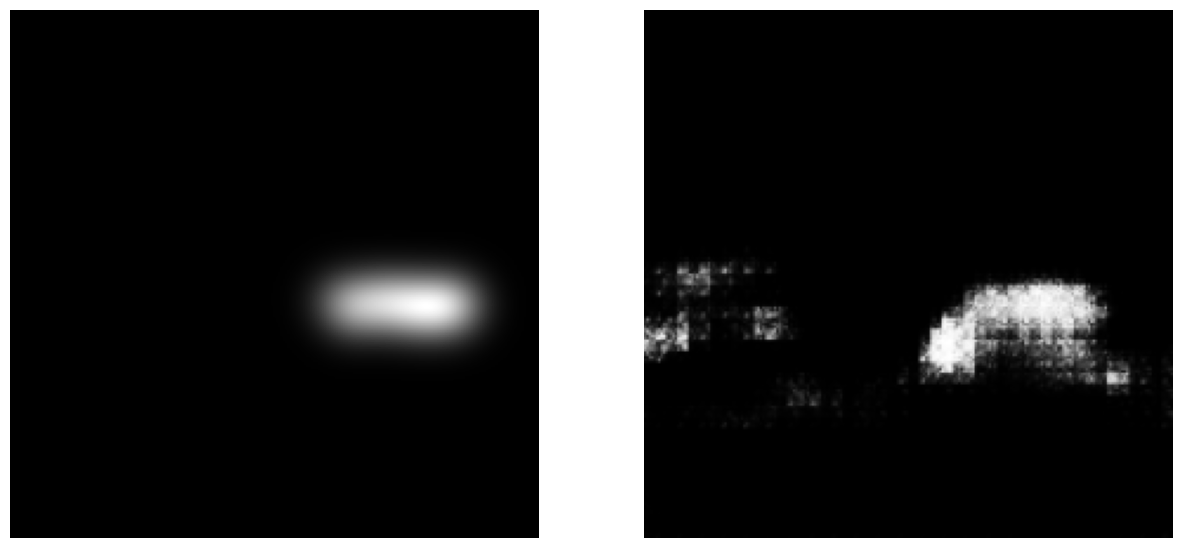

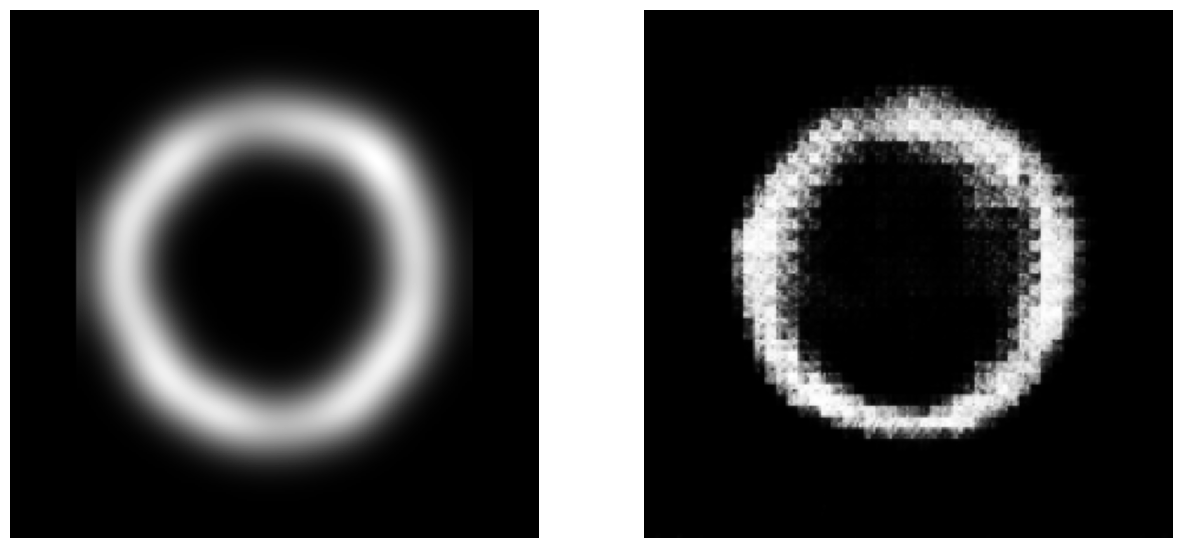

In [31]:
import matplotlib.pyplot as plt

# Display the image
new_images = [tgt_mask[0].detach().cpu().to(torch.float32).numpy(), src_mask[0].detach().cpu().to(torch.float32).numpy()]
show_sub_plot(new_images)
new_images = [tgt_mask[1].detach().cpu().to(torch.float32).numpy(), src_mask[1].detach().cpu().to(torch.float32).numpy()]
show_sub_plot(new_images)
